In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler
import transformers
from tqdm import tqdm, trange
import io
from utils import EarlyStopping
import matplotlib.pyplot as plt

########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Cuda available:  True


### Discover causal tweet dataset

Read some random tweets to get an idea about the labeling

*You will certainly find some mislabelings. Labeling causal relationships is challenging*

In [ ]:
dataPath = "data/causal_tweets_labeled.parquet"

data = pd.read_parquet(dataPath)
print(data.shape)
data.head()

### Preprocessing

In [4]:
##################### LOAD TWEETS (already split in sentences) ###########################

# The dataset above is the original one, which was labeled on a tweet level.
# This dataset contains the same tweets, but already split into sentences
# We simplified the problem by only studying causal relationships in a single sentence

dataPath = "../input/data/causal_sentences_labeled.parquet"

data = pd.read_parquet(dataPath)
print(data.shape)
data.head()

(20065, 6)


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,None,None,0.0,"[tonight, ,, I, learned, my, older, girl, will..."
1,Fiercely .,,None,None,0.0,"[Fiercely, .]"
2,#impressive #bigsister #type1 #type1times2,,None,None,0.0,"[#impressive, #bigsister, #type1, #type1times2]"
3,USER USER I knew diabetes and fibromyalgia wer...,joke,None,None,0.0,"[USER, USER, I, knew, diabetes, and, fibromyal..."
4,:face_with_rolling_eyes:,joke,None,None,0.0,[:face_with_rolling_eyes:]


In [5]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("Count of sentences before filtering: ", data.shape[0])
dataFiltered = data[~data["Intent"].str.contains("neg|joke|q")] 
dataFiltered = dataFiltered[dataFiltered["tokenized"].map(len) > 3] 
print("Count of sentences after filtering: ", dataFiltered.shape[0])
print("Distribution:")
print(dataFiltered["Causal association"].value_counts())
dataFiltered.head()


Count of sentences before filtering:  20065
Count of sentences after filtering:  16475
Distribution:
0.0    14364
1.0     2111
Name: Causal association, dtype: int64


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,None,None,0.0,"[tonight, ,, I, learned, my, older, girl, will..."
2,#impressive #bigsister #type1 #type1times2,,None,None,0.0,"[#impressive, #bigsister, #type1, #type1times2]"
5,:down_arrow: :down_arrow: :down_arrow: THIS :d...,,None,None,0.0,"[:down_arrow:, :down_arrow:, :down_arrow:, THI..."
6,I 'm a trans woman .,,None,None,0.0,"[I, 'm, a, trans, woman, .]"
7,"Both of us could use a world where "" brave and...",,None,None,0.0,"[Both, of, us, could, use, a, world, where, "",..."


In [6]:
####################### Stratified splits ####################

test_to_train_ratio = 0.1 # 10% test and 90% train
val_to_train_ratio = 0.2 


text = dataFiltered["sentence"].values.tolist()
labels = dataFiltered["Causal association"].values.tolist()

# first split the data into training and testing label in the ratio of 90:10
train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=test_to_train_ratio, stratify=labels, random_state=9)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=val_to_train_ratio, stratify=train_labels, random_state=9)


In [7]:
#################### Calculate class weights (for loss function) #########################

data_count_info = pd.Series(labels).value_counts(normalize=True)
train_count_info = pd.Series(train_labels).value_counts(normalize=True)
val_count_info = pd.Series(val_labels).value_counts(normalize=True)
test_count_info = pd.Series(test_labels).value_counts(normalize=True)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_count_info obtained above has fraction of samples
# for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_count_info)/len(train_count_info)

print("All: Count = {}, % of 0 = {}, % of 1 = {}".format(len(labels), *data_count_info.round(4).to_list()))
print("Train: Count = {}, % of 0 = {}, % of 1 = {}".format(len(train_labels), *train_count_info.round(4).to_list()))
print("Val: Count = {}, % of 0 = {}, % of 1 = {}".format(len(val_labels), *val_count_info.round(4).to_list()))
print("Test: Count = {}, % of 0 = {}, % of 1 = {}".format(len(test_labels), *test_count_info.round(4).to_list()))
print("Balancing class wts: for 0 = {}, for 1 = {}".format(*class_weight.round(4).to_list()))



All: Count = 16475, % of 0 = 0.8719, % of 1 = 0.1281
Train: Count = 11861, % of 0 = 0.8718, % of 1 = 0.1282
Val: Count = 2966, % of 0 = 0.8719, % of 1 = 0.1281
Test: Count = 1648, % of 0 = 0.872, % of 1 = 0.128
Balancing class wts: for 0 = 0.5735, for 1 = 3.9016


In [8]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
######### Create DataSet ################

class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.labels)

    
# datasets
train_dataset = TweetDataSet(train_texts, train_labels, tokenizer)
val_dataset = TweetDataSet(val_texts, val_labels, tokenizer)
test_dataset = TweetDataSet(test_texts, test_labels, tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))


# data loader
train_batch_size = 16
val_batch_size = 16
test_batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

## Evaluation Metrics

In [29]:
metrics_average = "binary" 

def compute_metrics(pred, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels,pred, average=metrics_average)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


### Model definition

In [26]:
class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5
    
model = CausalityBERT() ## just load the model trained in previous round here 
model.to(device)


In [31]:
########################### MODEL PARAMETERS ############################

lr = 1e-3    
adam_eps = 1e-8
epochs = 1
num_warmup_steps = 0


# fine-tune only the task-specific parameters
for param in model.bert.parameters():
    param.requires_grad = False

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) # scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0; after a warmup period durnig which it increases linearly from 0 to the initial lr set in the optimizer

## Loss function: penalising more for class with less number of exaplmes 
loss_fn = CrossEntropyLoss(torch.tensor(class_weight.to_list()).to(device))

In [15]:
################ TRAINING ##################

# initialise the early_stopping object
# early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)
early_patience = 5 # how long to wait after last time validation loss improved
early_stopping = EarlyStopping(patience=early_patience,verbose=True)


train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0

startTime = time.time()
for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")
    
    
    ########### training eval metrics #############################
    train_accuracy = []
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    ###################################################
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        ###########################################################################

        model.train()
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        #############################################################################

        loss = loss_fn(logits, labels)
        print("loss:", loss)
        loss.backward() # backward pass
        optim.step()    # update parameters and take a step up using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    
        ############# Training Accuracy Measure ###################################

        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        metrics = compute_metrics(pred_flat, labels_flat)        
        
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
        
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))
    print(F'\n\tTrain loss: {np.mean(train_loss)}')
    print(F'\n\ttrain acc: {np.mean(train_acc)}')
    print(F'\n\ttraining prec: {np.mean(train_prec)}')
    print(F'\n\ttraining rec: {np.mean(train_rec)}')
    print(F'\n\ttraining f1: {np.mean(train_f1)}')
    
    n_trained_epochs += 1
    
    ###################################################################################

    
    ## ---- Validation ------
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            ##################################################################################
            model.eval()
            logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 

                        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        metrics = compute_metrics(pred_flat, labels_flat)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])

    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))
    print(F'\n\tValidation loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    saveModelName = "./trained_models/causal_tweets_finetuned-{}-epochs-lr_{}.pth".format(n_trained_epochs-early_patience, lr) 
    early_stopping.path = saveModelName
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
endTime = time.time()
print(endTime-startTime)

Epoch:   0%|                                                 | 0/1 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>



  0%|                                                       | 0/38 [00:00<?, ?it/s]/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  3%|█▏                                             | 1/38 [00:06<04:09,  6.74s/it]

loss: tensor(0.6116, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|██▍       

loss: tensor(0.2237, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|███▋                                           | 3/38 [00:22<04:25,  7.58s/it]

loss: tensor(2.0967, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|████▉                                          | 4/38 [00:32<04:50,  8.55s/it]

loss: tensor(0.5613, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|██████▏                                        | 5/38 [00:41<04:56,  9.00s/it]

loss: tensor(1.2402, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|███████▍  

loss: tensor(0.3739, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|████████▋                                      | 7/38 [00:56<04:07,  7.97s/it]

loss: tensor(0.5786, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 21%|█████████▉                                     | 8/38 [01:02<03:45,  7.53s/it]

loss: tensor(0.7594, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|███████████▏                                   | 9/38 [01:10<03:37,  7.51s/it]

loss: tensor(0.6252, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|████████████                                  | 10/38 [01:16<03:22,  7.22s/it]

loss: tensor(0.6581, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|█████████████▎                                | 11/38 [01:23<03:08,  7.00s/it]

loss: tensor(0.7737, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|██████████████▌                               | 12/38 [01:29<02:58,  6.88s/it]

loss: tensor(0.5811, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 34%|███████████████▋                              | 13/38 [01:36<02:52,  6.89s/it]

loss: tensor(0.6281, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|████████████████▉                             | 14/38 [01:45<02:57,  7.38s/it]

loss: tensor(0.5812, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|██████████████████▏                           | 15/38 [01:52<02:47,  7.27s/it]

loss: tensor(0.3593, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|███████████████████▎                          | 16/38 [01:59<02:39,  7.24s/it]

loss: tensor(1.0037, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 45%|████████████████████▌                         | 17/38 [02:07<02:38,  7.54s/it]

loss: tensor(0.5846, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|█████████████████████▊                        | 18/38 [02:16<02:35,  7.78s/it]

loss: tensor(0.7219, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|███████████████████████                       | 19/38 [02:23<02:27,  7.74s/it]

loss: tensor(0.6246, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|████████████████████████▏                     | 20/38 [02:30<02:12,  7.35s/it]

loss: tensor(0.9018, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 55%|█████████████████████████▍                    | 21/38 [02:37<02:02,  7.21s/it]

loss: tensor(0.5897, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|██████████████████████████▋                   | 22/38 [02:44<01:58,  7.40s/it]

loss: tensor(0.7324, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|███████████████████████████▊                  | 23/38 [03:00<02:28,  9.93s/it]

loss: tensor(0.7329, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 63%|█████████████████████████████                 | 24/38 [03:10<02:19,  9.99s/it]

loss: tensor(0.6208, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 66%|██████████████████████████████▎               | 25/38 [03:22<02:14, 10.36s/it]

loss: tensor(0.6249, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 68%|███████████████████████████████▍              | 26/38 [03:30<01:58,  9.91s/it]

loss: tensor(0.6090, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|████████████████████████████████▋             | 27/38 [03:38<01:40,  9.09s/it]

loss: tensor(0.9835, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|█████████████████████████████████▉            | 28/38 [03:45<01:26,  8.68s/it]

loss: tensor(0.5733, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████████████████████████████████           | 29/38 [03:56<01:24,  9.34s/it]

loss: tensor(0.6503, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|████████████████████████████████████▎         | 30/38 [04:05<01:12,  9.10s/it]

loss: tensor(0.7064, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|█████████████████████████████████████▌        | 31/38 [04:11<00:58,  8.32s/it]

loss: tensor(0.6830, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 84%|██████████████████████████████████████▋       | 32/38 [04:18<00:47,  7.93s/it]

loss: tensor(0.7636, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|███████████████████████████████████████▉      | 33/38 [04:25<00:37,  7.56s/it]

loss: tensor(0.6280, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|█████████████████████████████████████████▏    | 34/38 [04:32<00:29,  7.25s/it]

loss: tensor(0.4215, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|██████████████████████████████████████████▎   | 35/38 [04:38<00:21,  7.02s/it]

loss: tensor(0.5585, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 95%|███████████████████████████████████████████▌  | 36/38 [04:45<00:13,  6.97s/it]

loss: tensor(0.5785, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|████████████████████████████████████████████▊ | 37/38 [04:52<00:06,  6.99s/it]

loss: tensor(0.9298, grad_fn=<NllLossBackward>)


/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████

loss: tensor(0.2900, grad_fn=<NllLossBackward>)

	Train loss: 0.688550565195711

	train acc: 0.6726973684210527

	training prec: 0.19157268170426067

	training rec: 0.4473684210526316

	training f1: 0.24163862453336132



  0%|                                                       | 0/38 [00:00<?, ?it/s]/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|█▏                                             | 1/38 [00:06<03:46,  6.11s/it]/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using _


	Validation loss: 0.5324451139098719

	Validation acc: 0.75

	Validation prec: 0.337844611528822

	Validation rec: 0.6622807017543859

	Validation f1: 0.41466165413533834
Validation loss decreased (inf --> 0.532445).  Saving model ...


Epoch: 100%|████████████████████████████████████████| 1/1 [09:27<00:00, 567.75s/it]

567.7661678791046


Plot of loss with epochs


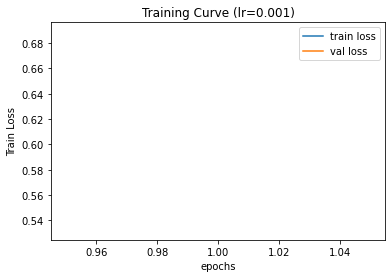

In [16]:
print("Plot of loss with epochs")
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

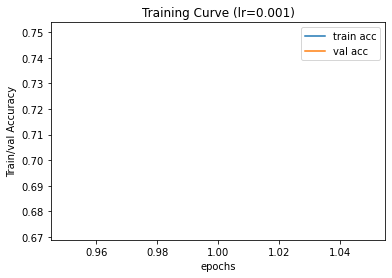

In [17]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

In [18]:
#loss_fn = CrossEntropyLoss()
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []


for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader

    with torch.no_grad():
        model.eval()
        logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 
    
    # move logits and labels to CPU
    logits = logits.detach().to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    metrics = compute_metrics(pred_flat, labels_flat)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])

    
print(F'\n\ttest loss: {np.mean(test_loss)}')
print(F'\n\ttest acc: {np.mean(test_acc)}')
print(F'\n\ttest prec: {np.mean(test_prec)}')
print(F'\n\ttest rec: {np.mean(test_rec)}')
print(F'\n\ttest f1: {np.mean(test_f1)}')





  0%|                                                       | 0/52 [00:00<?, ?it/s]/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  2%|▉                                              | 1/52 [00:20<17:43, 20.86s/it]/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  4%|█▊                                             | 2/52 [00:36<15:04, 18.08s/it]/var/folders/kr/xl7k0ks17bq191p_5d8z3x700000gn/T/ipykernel_10039/1071203384.py:16: DeprecationWarning: an integ


	test loss: nan

	test acc: 0.7355769230769231

	test prec: 0.26398777504546733

	test rec: 0.5991834554334554

	test f1: 0.35182295592661156



/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adrianahne/miniconda3/envs/dataCraft/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Apply classifier on diabetes tweets

In [68]:
from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re

# Define DataSet class again, just without the labels parameter this time.

tweet_tokenizer = TweetTokenizer()

# https://huggingface.co/vinai/bertweet-base
def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):

    tokens = tweet_tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.") .replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    
    return " ".join(normTweet.split())


class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, tokenizer):
        self.text = text
        #self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
             # , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.text)

    
softmax = torch.nn.Softmax(-1)
    

In [10]:
######### LOAD diabetes tweets #################

data_path = "data/diabetes_tweets_normalized.csv" 
diabetes_tweets = pd.read_csv(data_path, sep=";")#.sample(n=1000, random_state=1)
print("N:", diabetes_tweets.shape)
diabetes_tweets.head()

In [71]:
############# LOAD TOKENIZER  +++++++++++++++

bert_model = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(bert_model)


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /Users/adrianahne/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transfo

FileNotFoundError: [Errno 2] No such file or directory: './model-causal-tweet/model_4_finetuned-8-epochs-lr_1e-05.pth'

In [ ]:
################# load fine-tuned model ###################

# Or keep the model you trained and test it !


# Define here the model architecture of the fine-tuned model
class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5



finetuned_model = "models/causal_sentence_model-lr_1e-05.pth"

model = CausalityBERT() ## just load the model trained in previous round here 
model.load_state_dict(torch.load(finetuned_model, map_location='cpu')) # load model trained in previous round
model.to(device)

In [ ]:
############# Split tweets to sentences ###############

def split_into_sentences(text):
    """ Split tweet into sentences """
    
    text = " " + text + "  "
    text = text.replace("\n"," ")
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace("..", "<POINTPOINT>")
    text = text.replace(".",".<stop>")
    text = text.replace("<POINTPOINT>", "..")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    sentences = [s  for s in sentences if s != ""]
    return sentences


tweetsSplit = diabetes_tweets["text"].map(lambda text: split_into_sentences(normalizeTweet(text)))
print(tweetsSplit.shape[0])

sentences = tweetsSplit.explode()
print("tweets to sentences:", sentences.shape[0])

In [ ]:
######### Exclude questions and sentences with less than 5 words 
# and sentences without diabetes related keyword #################


trainingData = sentences[sentences.str.split(" ").str.len() > 5] # keep only sentence with more than 3 tokens
trainingData = trainingData[~trainingData.str.endswith("?")]
#trainingData = trainingData[trainingData.str.contains("|".join(diabetes_keywords))]

print("N sentences with > 5 words & no question & all with diabetes keyword:", trainingData.shape)

text = trainingData.values.tolist()

In [72]:
########## Get DataSet + DataLoader ###############

batch_size = 128
test_dataset = TweetDataSet(text, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    seed=0,
)

# we only use Trainer for inference
trainer = Trainer(model=model, args=training_args)
print("build trainer on device:", training_args.device, "with n gpus:", training_args.n_gpu)

logits = trainer.predict(test_dataset)

In [74]:
predictions = pd.Series(torch.argmax(torch.Tensor(logits.predictions),dim=1).flatten())
probas = pd.Series(torch.softmax(torch.Tensor(logits.predictions), dim = -1)[...,-1:].to('cpu').numpy().squeeze())


In [ ]:
causalDF = pd.DataFrame({"text":text, "causal_predictions": predictions, "proba":probas})
print("causal sentences:", causalDF.shape[0])
print(causalDF.causal_predictions.value_counts())
causalDF.head()

In [ ]:
for i, row in causalDF[0:100].iterrows():
    print(row["text"])
    print("pred:", row["causal_predictions"], "proba", row["proba"])
    print()
    

### For you to play, apply the classifier on the cancer tweets

In [ ]:
######### LOAD cancer tweets #################
import pandas as pd
tweets_cancer = pd.read_excel("data/cancer_tweets_personal.csv")
print(tweets_cancer.shape)
tweets_cancer.head()